[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ACS-IC-labs/IC-labs/blob/main/labs/lab08/lab8.ipynb)

# Laboratorul 08 - MAC

Prezentarea PowerPoint pentru acest laborator poate fi găsită [aici](https://drive.google.com/file/d/188HfjYdDqc97bPXiaF6tccVcU4pSy6-f/view).

În acest laborator vom studia despre Message Authentication Codes (MAC).


În Google Colab, puteți rula comezi shell (bash) folosind:
- `!` pentru a rula o singură linie în shell. Se poate intercala cu cod python.
- `%%bash` pentru a rula întreaga celulă în shell

Puteți vedea exemple în [acest tutorial](https://colab.research.google.com/notebooks/basic_features_overview.ipynb).

In [ ]:
!echo "Hello Crypto!"

In [ ]:
%%bash
echo "Hello Crypto!"

## Exercițiul 1 - OpenSSL în linia de comandă (3p)

**OpenSSL** este o suită de funcții criptografice, care oferă atât o facilitate de unelte în linie de comandă cât și o librărie folosită pentru aplicații (e.g. C/Python). Vom face câteva exerciții cu OpenSSL în linie de comandă ca să prindeți ceva experiență cu aceste funcții foarte populare și utile.

In [ ]:
!([ -f data_enc_mac.bin ] && [ -f data_kek.bin.pass_hellokitty ] && echo "Files already exist" \
    || (wget -O top_secret.zip https://github.com/ACS-IC-labs/IC-labs/raw/main/labs/lab08/top_secret.zip && unzip -o top_secret.zip))

Acum: Ați primit niște fișiere top secret în arhiva [`top_secret.zip`](https://github.com/ACS-IC-labs/IC-labs/blob/main/labs/lab08/top_secret.zip). Aceasta conține un fișier binar (`data_enc_mac.bin`) cu un mesaj criptat + un MAC, i.e.

```
file = Enc(ke,m) || MAC-CBC(km,m)
```

Vreți să aflați mesajul secret și să verificați că este corect (i.e., MAC corect). Pentru asta, vă trebuie cheile de criptare (`ke`) și de MAC (`km`). Știm că criptarea s-a făcut cu AES-128-CBC cu `iv=000.00` (16 octeți), iar MAC-ul este CMAC cu AES-128-CBC.

Din fericire, mai avem în arhivă un fișier (tot binar, `data_kek.bin.pass_hellokitty`) care conține un master key (`k0`), dar care este criptat și el cu AES-128-CBC și PBKDF2, cu passphrase din numele fișierului.

Mai știm că putem folosi acest master key (`k0`) pentru a deriva cheile de criptare și MAC de mai sus (`ke`, `km`) prin aplicarea funcției SHA256, i.e. `(ke, km) = SHA256(k0)`

Acum știm cam tot ce avem nevoie pentru a afla și a verifica mesajul secret. Care este acest mesaj?

Vedeți [aici](https://docs.openssl.org/3.0/man1/openssl-enc/) informații ajutătoare pentru criptare și criptare cu PBKDF2, [aici](https://docs.openssl.org/3.0/man1/openssl-dgst/) informații pentru SHA256 și [aici](https://www.openssl.org/docs/man3.0/man1/openssl-mac.html) pentru MAC.

* Începeți prin verificarea versiunii de OpenSSL (eu am folosit 3.0.2):

In [ ]:
%%bash
###############################################################################
# 1.  Decrypt the KEK file → k0  (NO “-nosalt” !)                             #
###############################################################################
k0=$(openssl enc -d -aes-128-cbc -pbkdf2 \
                 -in  data_kek.bin.pass_hellokitty \
                 -pass pass:hellokitty)
echo "k0  =  \"$k0\""
echo

###############################################################################
# 2.  Derive ke ‖ km  ←  SHA-256(k0)                                          #
###############################################################################
ke_km_hex=$(printf '%s' "$k0" | openssl dgst -sha256 -binary | xxd -p -c32)
ke=${ke_km_hex:0:32}     # first  32 hex chars = 16 B encryption key
km=${ke_km_hex:32:32}    # last   32 hex chars = 16 B MAC key
echo "ke  =  $ke"
echo "km  =  $km"
echo

###############################################################################
# 3.  Split data_enc_mac.bin  →  iv | ciphertext | tag                        #
###############################################################################
iv=$(head -c16 data_enc_mac.bin | xxd -p)          # 16-byte IV
mac_expected=$(tail -c16 data_enc_mac.bin | xxd -p)# last 16 B = CMAC tag
# everything in-between is the ciphertext (must be multiple of 16 B)
dd if=data_enc_mac.bin bs=1 skip=16 count=$(( $(stat -c%s data_enc_mac.bin) - 32 )) \
   of=cipher.bin 2>/dev/null
echo "iv  =  $iv"
echo "tag(expected) = $mac_expected"
echo

###############################################################################
# 4.  Decrypt ciphertext (AES-128-CBC, **no padding**)                        #
###############################################################################
openssl enc -d -aes-128-cbc -nopad -K "$ke" -iv "$iv" \
        -in cipher.bin -out message.txt
echo "-----  Decrypted message  --------------------------------------------"
cat message.txt
echo
echo "------------------------------------------------------------------------"
echo

###############################################################################
# 5.  Check CMAC(tag)                                                         #
###############################################################################
mac_calc=$(openssl mac -cipher AES-128-CBC -macopt hexkey:$km -binary \
                      < message.txt | xxd -p)
echo "tag(calculated) = $mac_calc"

[[ "$mac_calc" == "$mac_expected" ]] \
  && echo "✔  MAC verified – message is authentic." \
  || echo "✘  MAC mismatch – wrong key or corrupted file!"



* Apoi, decriptați fișierul binar `kek` cu passphrase-ul din numele fișierului pentru a obține `k0` (vedeți `openssl enc ... -pbkdf2 ...`).

In [ ]:
%%bash
# „hellokitty” e passphrase-ul (extras din numele fișierului)
openssl enc -d -aes-128-cbc -pbkdf2 \
    -in data_kek.bin.pass_hellokitty \
    -out k0.bin \
    -pass pass:hellokitty

wc -c k0.bin   # trebuie să afişeze 16


# TODO: openssl enc -d -aes128 -pbkdf2 -in ...


* Acum, folosiți SHA256 pentru a obține `(ke|km) = SHA256(k0)`. Vedeți `openssl -dgst`. Puteți face pipe ca să trimiteți date de intrare către SHA256 sau alte funcții openssl, e.g.:
```bash
echo $k0 | openssl dgst -sha256
```
unde `k0` conține cheia aflată la punctul precedent (hint: ar trebui sa fie gustoasă...).

In [ ]:
%%bash
openssl dgst -sha256 -binary k0.bin > kekm.bin
hexdump -C kekm.bin      # vezi digest-ul (32 octeţi)
# TODO: echo $k0 | openssl dgst -sha256


Cu `ke` (primii 16 octeți din rezultatul de mai sus) putem decripta mesajul (folosiți `-nopad`, nu e nevoie de padding). Vedeți `openssl enc -d ...`. Aici trebuie să folosiți primii `N-16` octeți din fișier (ultimii 16 sunt MAC-ul). Puteți trunchia cu cât sau altă metodă la alegere, e.g.:
```bash
cat data_enc_mac.bin | head -c80
```
apoi folosiți iarăși `openssl enc -aes128 -d -K ... -iv ... -nopad` (cu parametru în fișier sau cu pipe ca mai sus) ca să decriptați mesajul.

In [ ]:
%%bash
# Lungimea totală:
total=$(stat -c%s data_enc_mac.bin)
# Criptograma, tot minus ultimii 16 octeţi:
ct_len=$((total-16))
head -c "$ct_len" data_enc_mac.bin > ciphertext.bin
# MAC-ul:
tail -c 16 data_enc_mac.bin > mac_orig.bin

openssl enc -d -aes-128-cbc -nopad \
    -K  "$ke_hex" \
    -iv 00000000000000000000000000000000 \
    -in ciphertext.bin \
    -out message.txt
cat message.txt

# TODO: cat data_enc_mac.bin | head -c80 | ...


În sfârșit, puteți verifica că mesajul primit este corect (deși ar trebui să pară un text inteligibil) prin aplicarea MAC-ului CMAC cu AES-128-CBC peste mesajul descoperit anterior, cu ultimii 16 octeți din fișierul binar `data_enc_mac.bin`. Vedeți funcția
```bash
openssl mac -cipher AES-128-CBC -binary
```
cu parametrul `-macopt hexkey:...` (aici `km` în hexa)

In [ ]:
%%bash
openssl mac -mac CMAC \
    -macopt cipher:AES-128-CBC \
    -macopt hexkey:$km_hex \
    -binary \
    -in message.txt \
    > mac_calc.bin


cmp mac_calc.bin mac_orig.bin && echo "MAC OK!" || echo "MAC FAIL!"

# TODO: openssl mac -cipher AES-128-CBC -binary
# Then, check if the output matches the last 16 bytes of the file data_enc_mac.bin


## Exercițiul 2 - Birthday attack (7p)

În acest exercițiu vom implementa Birthday attack pentru algoritmul SHA-1 folosind OpenSSL.

Scopul acestui atac este să obțină o coliziune pentru algoritmul de hashing SHA-1 folosind 2 mesaje $M_1$ și $M_2$, astfel încât pentru **primii 4** bytes cele două hash digest-uri să fie egale ($\mathsf{SHA1}(M_1) = \mathsf{SHA1}(M_2)$).

Coliziunea trebuie să aibă o lungime de $32$ biți, ceea ce înseamnă că sunt necesare $2^{16}$ mesaje random pentru a efectua atacul. De reținut este că atacul nu este garantat să funcționeze din prima iterație; în medie, sunt necesare 2 iterații ale atacului pentru a găsi o coliziune.

Față de laboratoarele anterioare, acest laborator va fi realizat în C folosind scheletul de cod sau implementând atacul de la zero.

Pentru a obține digest-ul `md` de lungime `md_len` prin algoritmul de hashing SHA1 folosind OpenSSL pentru un buffer `buffer` de lungime `length`, puteți folosi următorul exemplu:

``` c
unsigned char md[EVP_MAX_MD_SIZE];  /* SHA-1 outputs 160-bit digests */
unsigned int md_len;                /* Length of the hash */

EVP_MD_CTX *mdctx = EVP_MD_CTX_new();

if (!EVP_DigestInit_ex2(mdctx, EVP_sha1(), NULL)) {
    printf("Message digest initialization failed.\n");
    EVP_MD_CTX_free(mdctx);
    exit(1);
}
if (!EVP_DigestUpdate(mdctx, buffer, length)) {
    printf("Message digest update failed.\n");
    EVP_MD_CTX_free(mdctx);
    exit(1);
}
if (!EVP_DigestFinal_ex(mdctx, md, &md_len)) {
    printf("Message digest finalization failed.\n");
    EVP_MD_CTX_free(mdctx);
    exit(1);
}

EVP_MD_CTX_free(mdctx);
```

Puteți consulta documentația de aici: https://docs.openssl.org/3.0/man3/EVP_DigestInit/

**Notă:** Fișierele descărcate sunt salvate doar temporar! Dacă mașina virtuală este închisă, datele se pierd. Pentru a vă asigura persistența salvați-vă fișierele în Google Drive.

Puteți rula celula de mai jos pentru a seta `cwd` (current working directory) în drive-ul vostru.

**Notă:** Înainte de a rula o celulă în Colab precum cea de mai jos, mereu inspectați întreg codul înainte, să vă asigurați că nu sunt chestii malițioase în spate!

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')

    # TODO: Set a path where to save the files, inside your Google Drive. Maybe
    # you would like to mkdir beforehand.
    %cd /content/gdrive/MyDrive/<PATH_TO_YOUR_DIR>
except:
    print("Using local disk")

Descărcarea scheletului de laborator:

In [ ]:
!([ -f birthday.tar.gz ] && [ -f birthday.c ] && echo "Skeleton already exists") \
    || (wget https://github.com/ACS-IC-labs/IC-labs/raw/refs/heads/main/labs/lab08/birthday.tar.gz && tar xvf birthday.tar.gz)

Codul sursă se găsește în `birtday.c`. Pentru a edita fișierul, 1) deschideți tabul `Files` din dreapta, 2) căutați directorul în care ați descărcat labul și dați dublu-click pe `birthday.c` și 3) lucrați în fereastra deschisă în dreapta.

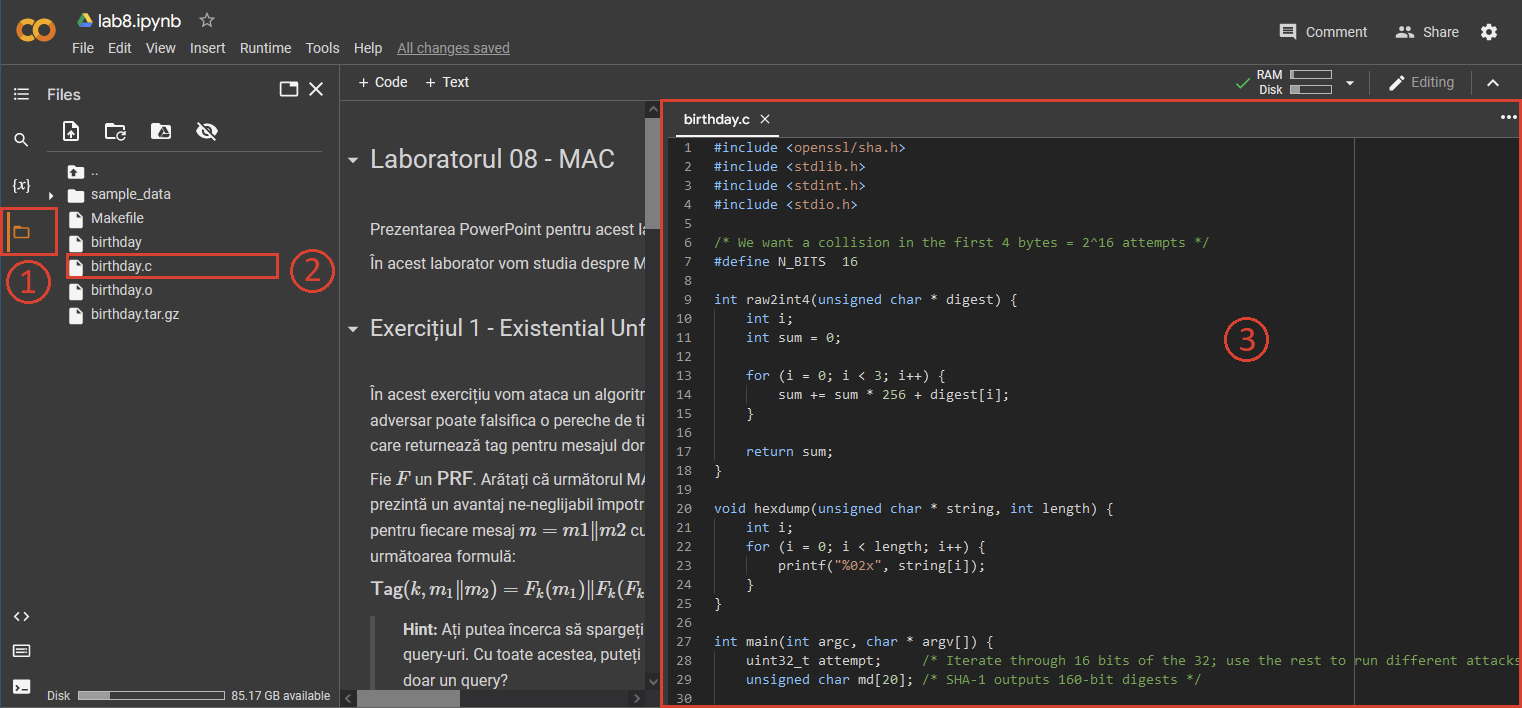

În cazul în care salvați pe Google Drive, sistemul de fișiere va arăta ca mai jos. În `gdrive/MyDrive` căutați unde v-ați descărcat labul.

> **Hint:** dacă nu știți calea, puteți să apelați comanda `pwd` în Colab.
``` bash
!pwd
```

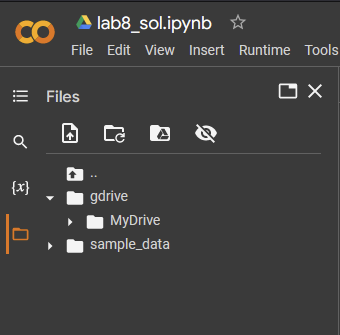

Compilare surse:

In [ ]:
!make

Rulare executabil:

In [ ]:
!./birthday